#Loading Dataset

In [0]:
!pip install -q kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"writammallik","key":"e5e3703be39ae2165480979852bc602d"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 96% 241M/251M [00:04<00:00, 57.9MB/s]
100% 251M/251M [00:04<00:00, 60.1MB/s]


In [0]:
from zipfile import ZipFile

file_name = "/content/amazon-fine-food-reviews.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


#Importing Dependencies

In [0]:
from attention import AttentionLayer     #Custom Attention Layer

In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import nltk
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#Reading Dataset

In [0]:
data=pd.read_csv("Reviews.csv")

In [0]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [0]:
data.sample(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
291957,291958,B001EO5Y8Y,AUW39XSPQBROK,Carol Forbess,3,5,4,1314316800,Coffee good; kcups environmentally questionable,"We have had our Keurig for over a year.<br />When it arrived, we let out a cheer.<br />So convenient, so quick, one might not think twice<br />But the waste with the packaging isn't so nice.<br />..."
300203,300204,B001Q9EGFE,A1ZKGSDVP057L9,Mariane Matera,0,0,3,1248480000,Cats Ate It But Didn't Go Crazy For It,"My title says it all. The cats all like treats, and they ate this bag, but then didn't go crazy for it. So it would depend on the price whether I bought it or not."
466297,466298,B0089Q2A8M,A27W93IR4ET1AP,Ain't No Excuse,4,4,5,1306454400,Amazing flavor,"Open the bag, close you eyes, and smell--you'd swear it was popcorn from the movie theater. As a suffer of diverticulosis I cannot eat popcorn (the hulls are the problem). POPCORNERS came as if th..."
177778,177779,B0012IP658,A2L6CVX9YGRSGF,Michelle,2,2,5,1288224000,Delicious Yogurt Topper,This makes a great snack to keep on hand the office. Very tasty on top of yogurt (put it in the freezer for about 45 minutes for a great summer treat).
488475,488476,B0013A0QXC,A4YNLU4SGKYM8,Fernandina Nina,1,1,5,1344902400,Good ol' Senseo,I have a Senseo single serve coffee maker that has been working beautifully for years. It uses recyclable paper pods that are like tea bags -- so there is no metal or plastic waste associated wit...


In [0]:
data.drop_duplicates(subset=['Text'],inplace=True)        #dropping duplicates
data.dropna(axis=0,inplace=True)                          #dropping null values

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393565 entries, 0 to 568453
Data columns (total 10 columns):
Id                        393565 non-null int64
ProductId                 393565 non-null object
UserId                    393565 non-null object
ProfileName               393565 non-null object
HelpfulnessNumerator      393565 non-null int64
HelpfulnessDenominator    393565 non-null int64
Score                     393565 non-null int64
Time                      393565 non-null int64
Summary                   393565 non-null object
Text                      393565 non-null object
dtypes: int64(5), object(5)
memory usage: 33.0+ MB


#Preprocessing

In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have","why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

##Text Cleaning

In [0]:
data['Text'][:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

In [0]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [0]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [0]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

##Summary Cleaning

In [0]:
data['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [0]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

In [0]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

In [0]:
cleaned_summary[:10]

['good quality dog food ',
 'not as advertised ',
 'delight says it all ',
 'cough medicine ',
 'great taffy ',
 'nice taffy ',
 'great just as good as the expensive brands ',
 'wonderful tasty taffy ',
 'yay barley ',
 'healthy dog food ']

In [0]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [0]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [0]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

##Visualizing Distribution of Sequence

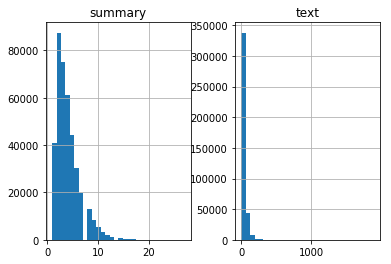

In [0]:
text_word_count = []
summary_word_count = []

for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [0]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=10):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9798943090671427


In [0]:
max_text_len=30
max_summary_len=10

In [0]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)

#Tokenizer

In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(lower=False) 
x_tokenizer.fit_on_texts(list(x_tr))

In [0]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 68.13136025532583
Total Coverage of rare words: 0.7808281930721221


##Text Tokenizer

In [0]:
#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_text_len, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_text_len, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [0]:
x_voc_size

114678

##Summary Tokenizer

In [0]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer(lower=False)
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_summary_len, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [0]:
y_voc_size

31030

#Building Model

In [0]:
latent_dim = 300
embedding_dim=100

In [0]:
# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc_size, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc_size, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

W0901 04:00:37.873934 139808063059840 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0901 04:00:37.895265 139808063059840 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      11467800    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

In [0]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=30,batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

W0901 04:03:00.622376 139808063059840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 353899 samples, validate on 39323 samples
Epoch 1/30
353899/353899 [==============================] - 691s 2ms/sample - loss: 2.2789 - acc: 0.6883 - val_loss: 1.9465 - val_acc: 0.7102
Epoch 2/30
353899/353899 [==============================] - 688s 2ms/sample - loss: 1.9080 - acc: 0.7134 - val_loss: 1.7670 - val_acc: 0.7264
Epoch 3/30
353899/353899 [==============================] - 689s 2ms/sample - loss: 1.7822 - acc: 0.7239 - val_loss: 1.6838 - val_acc: 0.7340
Epoch 4/30
353899/353899 [==============================] - 688s 2ms/sample - loss: 1.7120 - acc: 0.7299 - val_loss: 1.6366 - val_acc: 0.7383
Epoch 5/30
353899/353899 [==============================] - 688s 2ms/sample - loss: 1.6629 - acc: 0.7340 - val_loss: 1.6072 - val_acc: 0.7406
Epoch 6/30
353899/353899 [==============================] - 688s 2ms/sample - loss: 1.6269 - acc: 0.7369 - val_loss: 1.5802 - val_acc: 0.7435
Epoch 7/30
353899/353899 [==============================] - 688s 2ms/sample - loss: 1.5985 - acc:

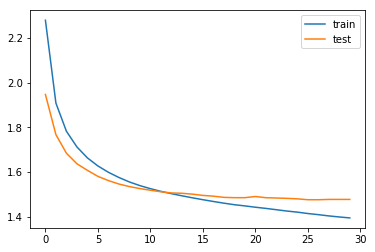

In [0]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

#Inference

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],[decoder_outputs2] + [state_h2, state_c2])

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='END'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'END' or len(decoded_sentence.split()) >= (max_summary_len-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [0]:
for i in range(0,100):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
  print("\n")